In [3]:
# Import all necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing, tree
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Read CSV file and put it inside dataframe
df = pd.read_csv('train.csv')

# Show number of attributes
print(f'Number of attributes: {df.shape[1]}')

# Show names of attributes
print(f'Name of attributes: {df.columns}')

# Show number of instances
print(f'Number of instances: {df.shape[0]}')

# Show columns and top 5 rows
df.head()

Number of attributes: 12
Name of attributes: Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Number of instances: 891


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Check for duplicates after dropping PassengerId 
df = df.drop(columns='PassengerId')
print(f'Number of duplicated rows: {df.duplicated().sum()}')

# Show only columns with missing data
missing_data = df.isnull().sum()
print(f'{missing_data[missing_data > 0]}')

# Check columns that have more than 50% missing data
missing_proportion = df.isnull().mean()
columns_to_drop = missing_proportion[missing_proportion > 0.5]

# Drop those columns together with "Name" and "Ticket" columns
df = df.drop(columns=['Name','Ticket'] + list(columns_to_drop.index))


Number of duplicated rows: 0
Age         177
Cabin       687
Embarked      2
dtype: int64
Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64


In [5]:
# Bin Age column into AgeGroup
df['AgeGroup'] = df['Age'].apply(lambda x:
                                        'NK' if pd.isnull(x) else
                                        'Child' if x < 16 else
                                        'Youth' if x < 30 else
                                        'Adult' if x < 65 else
                                        'Senior')


# Define the bins and labels
bins = [-float('inf'), 0, 3, float('inf')]  
labels = ['None', 'Few', 'Many'] 

# Create new 'Relatives' column based on number of relatives 
df['Relatives'] = pd.cut(df['Parch'] + df['SibSp'] , bins=bins, labels=labels)

df['Fare'] = df['Fare'].apply(lambda x:
                                        'Free' if x == 0 else
                                        'Low' if x < 50 else
                                        'Average' if x < 100 else
                                        'High')

# Drop SibSp, Parch, Age columns
df = df.drop(columns=['SibSp','Parch','Age'])
print(f'Number of attributes: {df.shape[1]}')
print(f'Name of attributes: {df.columns}')

Number of attributes: 7
Name of attributes: Index(['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'AgeGroup',
       'Relatives'],
      dtype='object')


In [6]:
# Change Pclass into category datatype
df['Pclass'] = df['Pclass'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Survived   891 non-null    int64   
 1   Pclass     891 non-null    category
 2   Sex        891 non-null    object  
 3   Fare       891 non-null    object  
 4   Embarked   889 non-null    object  
 5   AgeGroup   891 non-null    object  
 6   Relatives  891 non-null    category
dtypes: category(2), int64(1), object(4)
memory usage: 36.9+ KB


In [7]:
# Do one-hot encoding
data_encoded = pd.get_dummies(df,drop_first = True)
data_encoded.head()

,Survived,Pclass_2,Pclass_3,Sex_male,Fare_Free,Fare_High,Fare_Low,Embarked_Q,Embarked_S,AgeGroup_Child,AgeGroup_NK,AgeGroup_Senior,AgeGroup_Youth,Relatives_Few,Relatives_Many
0,0,False,True,True,False,False,True,False,True,False,False,False,True,True,False
1,1,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,1,False,True,False,False,False,True,False,True,False,False,False,True,False,False
3,1,False,False,False,False,False,False,False,True,False,False,False,False,True,False
4,0,False,True,True,False,False,True,False,True,False,False,False,False,False,False


In [8]:
# Split data into training and testing data
label = data_encoded['Survived']
attributes = data_encoded.drop(columns='Survived')

attributes_train, attributes_test, label_train, label_test = train_test_split(attributes, label, test_size=0.3)

attributes_train.info()
label_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 623 entries, 751 to 878
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Pclass_2         623 non-null    bool 
 1   Pclass_3         623 non-null    bool 
 2   Sex_male         623 non-null    bool 
 3   Fare_Free        623 non-null    bool 
 4   Fare_High        623 non-null    bool 
 5   Fare_Low         623 non-null    bool 
 6   Embarked_Q       623 non-null    bool 
 7   Embarked_S       623 non-null    bool 
 8   AgeGroup_Child   623 non-null    bool 
 9   AgeGroup_NK      623 non-null    bool 
 10  AgeGroup_Senior  623 non-null    bool 
 11  AgeGroup_Youth   623 non-null    bool 
 12  Relatives_Few    623 non-null    bool 
 13  Relatives_Many   623 non-null    bool 
dtypes: bool(14)
memory usage: 13.4 KB
<class 'pandas.core.series.Series'>
Index: 623 entries, 751 to 878
Series name: Survived
Non-Null Count  Dtype
--------------  -----
623 non-null    int64


In [9]:
# Train the model on the training data
model = DecisionTreeClassifier(max_depth=3)
model.fit(attributes_train, label_train)

# Predict survivors in testing set
label_pred = model.predict(attributes_test)
print(f'Number of survivors in testing set: {label_pred.sum()} out of {label_pred.size}')

Number of survivors in testing set: 106 out of 268


In [10]:
# Show accuracy and confusion matrix
accuracy = accuracy_score(label_test, label_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

ConfusionMatrix = confusion_matrix(label_test,label_pred)
print(ConfusionMatrix)

Accuracy: 81.34%
[[137  25]
 [ 25  81]]


In [11]:
# Show the tree rules
tree_rules = export_text(model, feature_names=list(attributes.columns))
print(tree_rules)

|--- Sex_male <= 0.50
|   |--- Pclass_3 <= 0.50
|   |   |--- Fare_Low <= 0.50
|   |   |   |--- class: 1
|   |   |--- Fare_Low >  0.50
|   |   |   |--- class: 1
|   |--- Pclass_3 >  0.50
|   |   |--- Relatives_Many <= 0.50
|   |   |   |--- class: 1
|   |   |--- Relatives_Many >  0.50
|   |   |   |--- class: 0
|--- Sex_male >  0.50
|   |--- AgeGroup_Child <= 0.50
|   |   |--- Pclass_3 <= 0.50
|   |   |   |--- class: 0
|   |   |--- Pclass_3 >  0.50
|   |   |   |--- class: 0
|   |--- AgeGroup_Child >  0.50
|   |   |--- Relatives_Many <= 0.50
|   |   |   |--- class: 1
|   |   |--- Relatives_Many >  0.50
|   |   |   |--- class: 0



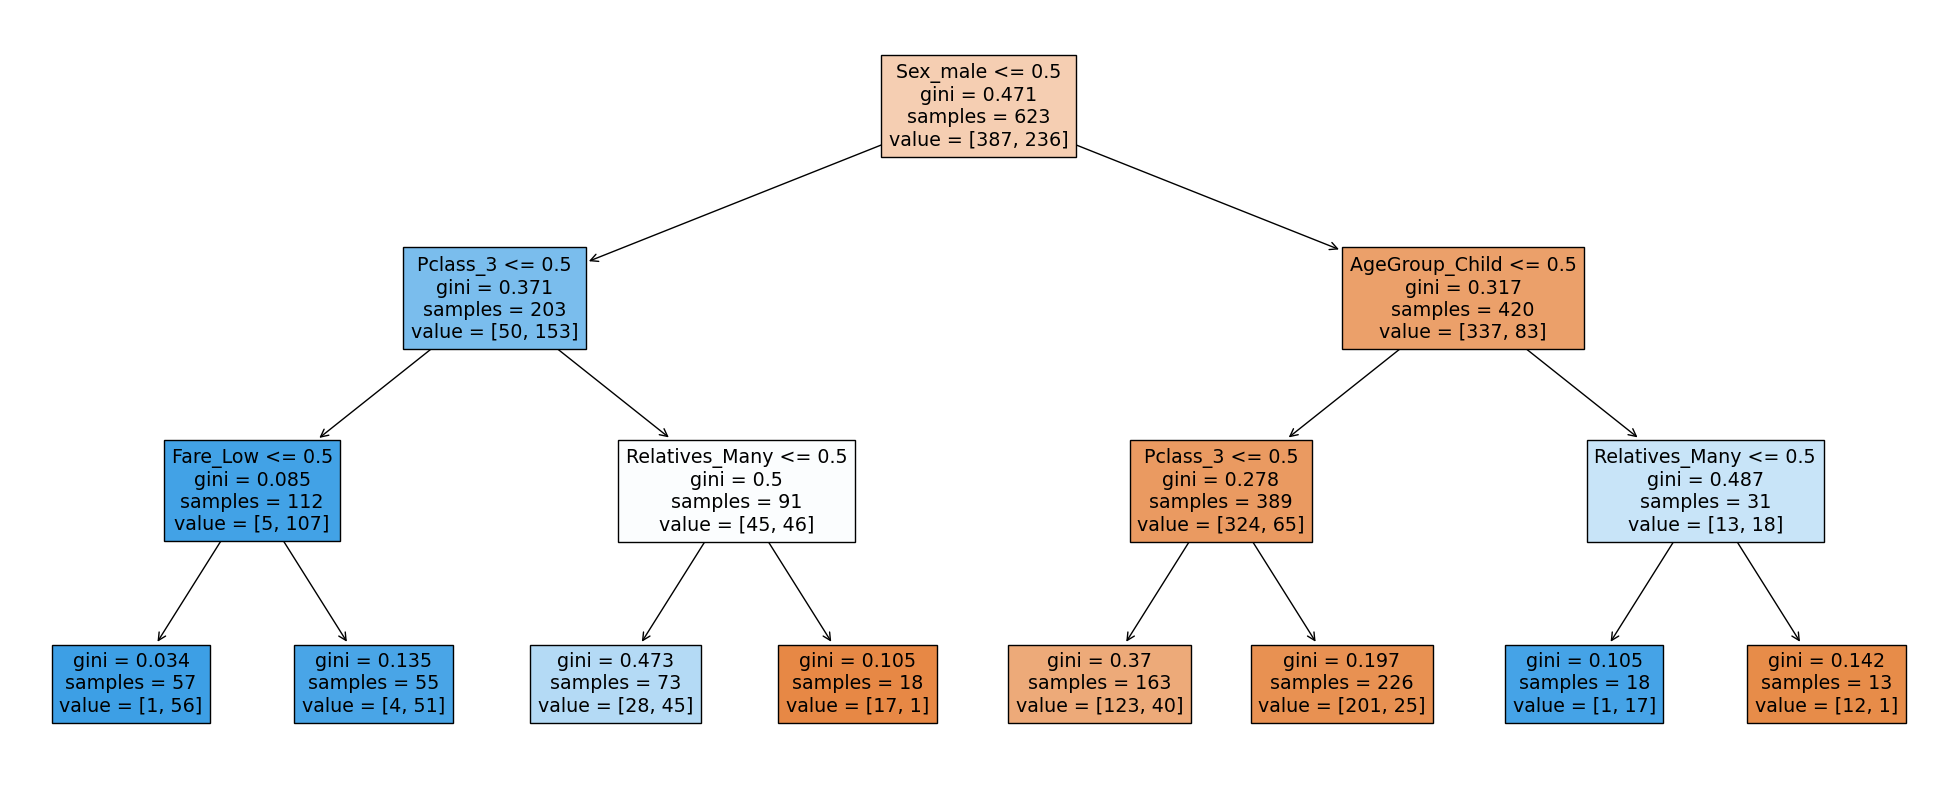

In [12]:
# Create the tree diagram
fig = plt.figure(figsize=(25,10))
tree.plot_tree(model, feature_names=attributes_train.columns, filled=True)
plt.show()